1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.
​
2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .
3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.
4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.
5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10*i-й до (i+1)*10 -й,... ,от 90 до 100-й точках (используйте осреденение по десяткам точек)
​
6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

In [139]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns

import os

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV

#### 1-3

In [140]:
data = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])
data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [141]:
data_w=data.resample('W').mean()
data_w.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0,3.517483,11.58042,0.160839,0.000000,0.167832
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0,3.000000,11.50000,0.000000,0.000000,0.000000
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0,3.000000,11.50000,0.000000,0.142857,0.000000
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,3.000000,11.50000,0.142857,0.000000,0.142857
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,3.000000,11.50000,0.000000,0.000000,0.000000


In [142]:
def split_data(data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

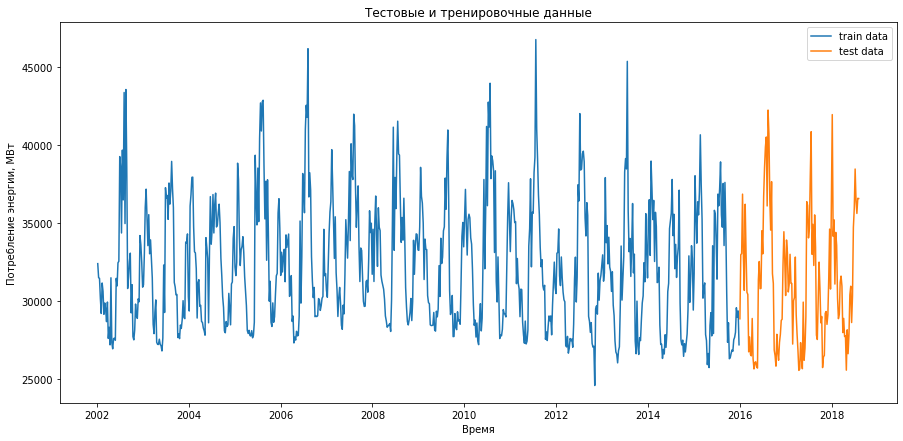

In [143]:
train, test = split_data(data_w, '01-01-2016')

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [144]:
h=1
p=14
X_train_1 = train.iloc[p:-h,:]
Y_train_1 = train[train.columns[0]].values[h+p:]
X_test_1 = test.iloc[p:-h,:]
Y_test_1 = test[test.columns[0]].values[h+p:]

In [145]:
h=4
p=14
X_train_4 = train.iloc[p:-h,:]
Y_train_4 = train[train.columns[0]].values[h+p:]
X_test_4 = test.iloc[p:-h,:]
Y_test_4 = test[test.columns[0]].values[h+p:]

Расчет для h=1

Определение оптимальных параметров для расчета модели

In [146]:
def report(results, n_top=40):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

param_dist = {"max_depth": [3, 2,10,14,5], 
              "n_estimators":[100,200,300,400,500, 1000, 1200,1500]}

#  randomized search
n_iter_search = 10

model_gr =GradientBoostingRegressor()

random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)

random_search.fit(X_train_1, Y_train_1)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.688 (std: 0.037)
Parameters: {'n_estimators': 300, 'max_depth': 3}

Model with rank: 2
Mean validation score: 0.683 (std: 0.052)
Parameters: {'n_estimators': 300, 'max_depth': 2}

Model with rank: 3
Mean validation score: 0.669 (std: 0.031)
Parameters: {'n_estimators': 100, 'max_depth': 5}

Model with rank: 4
Mean validation score: 0.655 (std: 0.038)
Parameters: {'n_estimators': 200, 'max_depth': 5}

Model with rank: 5
Mean validation score: 0.634 (std: 0.059)
Parameters: {'n_estimators': 1000, 'max_depth': 2}

Model with rank: 6
Mean validation score: 0.627 (std: 0.060)
Parameters: {'n_estimators': 1200, 'max_depth': 2}

Model with rank: 7
Mean validation score: 0.585 (std: 0.049)
Parameters: {'n_estimators': 400, 'max_depth': 10}

Model with rank: 8
Mean validation score: 0.585 (std: 0.042)
Parameters: {'n_estimators': 1000, 'max_depth': 10}

Model with rank: 9
Mean validation score: 0.497 (std: 0.067)
Parameters: {'n_estimators': 100, 'max

In [147]:
model_data_1 = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)

In [148]:
model_data_1.fit( X_train_1, Y_train_1 )

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [149]:
Y_test_pred_1 = model_data_1.predict(X_test_1)

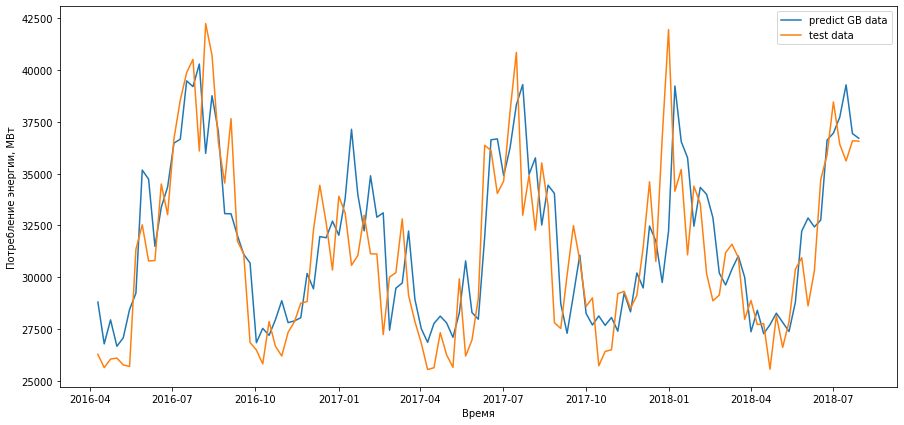

In [151]:
h=1
p=14
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[p:-h],Y_test_pred_1, label='predict GB data' )
plt.plot(test.index[p:-h],Y_test_1, label='test data')

plt.legend()
plt.show()

In [152]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [153]:
er_1_mape = mean_absolute_percentage_error(Y_test_1,Y_test_pred_1)

print('ошибка градиентного бустинга MAPE :  ', er_1_mape,'%')

ошибка градиентного бустинга MAPE :   6.400763958545917 %


In [154]:
er_1_mse = mean_squared_error(Y_test_1, Y_test_pred_1) 
er_1_mae = mean_absolute_error(Y_test_1, Y_test_pred_1) 
er_1_r2 = r2_score(Y_test_1, Y_test_pred_1)

print('ошибка mse :  ', er_1_mse,'\nошибка mae  :  ', er_1_mae,'\nоценка R2 :  ', er_1_r2)

ошибка mse :   6967536.6979361335 
ошибка mae  :   2005.0940504472553 
оценка R2 :   0.596035212052082


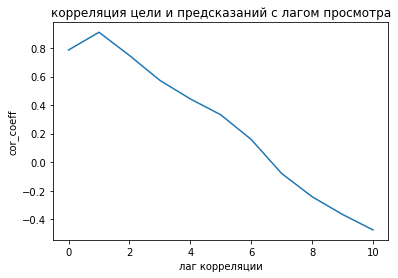

In [155]:
lag=10
p_cor=[np.corrcoef(Y_test_1, Y_test_pred_1)[1,0]]
for i in range(lag):
    c=np.corrcoef( Y_test_1[:-(i+1)], Y_test_pred_1[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) )  
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция цели и предсказаний с лагом просмотра')
plt.show()

In [156]:
def report(results, n_top=40):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

param_dist = {"max_depth": [3, 2,10,14,5], 
              "n_estimators":[100,200,300,400,500, 1000, 1200,1500]}

#  randomized search
n_iter_search = 10

model_gr =GradientBoostingRegressor()

random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)

random_search.fit(X_train_4, Y_train_4)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.637 (std: 0.068)
Parameters: {'n_estimators': 100, 'max_depth': 3}

Model with rank: 2
Mean validation score: 0.582 (std: 0.066)
Parameters: {'n_estimators': 1500, 'max_depth': 5}

Model with rank: 3
Mean validation score: 0.576 (std: 0.086)
Parameters: {'n_estimators': 1500, 'max_depth': 2}

Model with rank: 4
Mean validation score: 0.550 (std: 0.094)
Parameters: {'n_estimators': 1000, 'max_depth': 3}

Model with rank: 5
Mean validation score: 0.544 (std: 0.097)
Parameters: {'n_estimators': 1200, 'max_depth': 3}

Model with rank: 6
Mean validation score: 0.497 (std: 0.091)
Parameters: {'n_estimators': 500, 'max_depth': 10}

Model with rank: 7
Mean validation score: 0.410 (std: 0.136)
Parameters: {'n_estimators': 500, 'max_depth': 14}

Model with rank: 8
Mean validation score: 0.408 (std: 0.140)
Parameters: {'n_estimators': 300, 'max_depth': 14}

Model with rank: 9
Mean validation score: 0.406 (std: 0.134)
Parameters: {'n_estimators': 400, 'm

Расчет для h=4

In [157]:
model_data_4 = GradientBoostingRegressor(max_depth=3, random_state=0, n_estimators=100)

In [158]:
model_data_4.fit(X_train_4, Y_train_4 )

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [159]:
Y_test_pred_4 = model_data_4.predict(X_test_4)

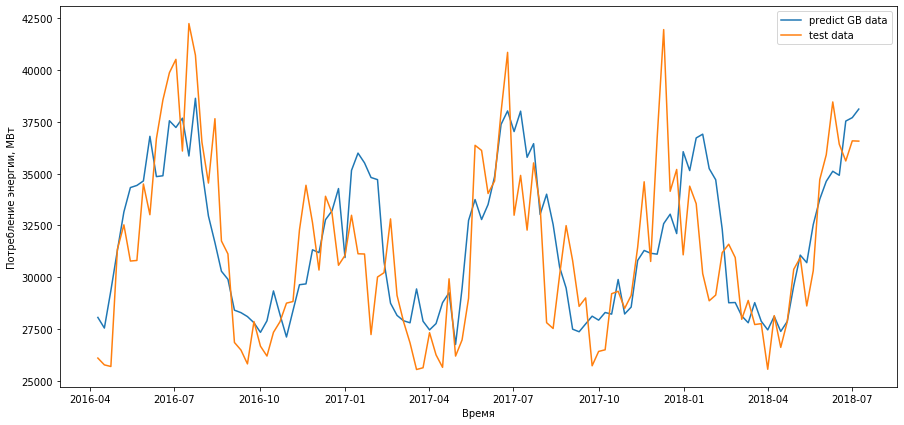

In [160]:
h=4
p=14
plt.figure(figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[p:-h],Y_test_pred_4, label='predict GB data' )
plt.plot(test.index[p:-h],Y_test_4, label='test data')

plt.legend()
plt.show()

In [161]:
er_4_mape = mean_absolute_percentage_error(Y_test_4,Y_test_pred_4)

print('ошибка градиентного бустинга MAPE :  ', er_4_mape,'%')

ошибка градиентного бустинга MAPE :   6.933030912420874 %


In [162]:
er_4_mse = mean_squared_error(Y_test_4, Y_test_pred_4) 
er_4_mae = mean_absolute_error(Y_test_4, Y_test_pred_4) 
er_4_r2 = r2_score(Y_test_4, Y_test_pred_4)

print('ошибка mse :  ', er_4_mse,'\nошибка mae  :  ', er_4_mae,'\nоценка R2 :  ', er_4_r2)

ошибка mse :   8186772.953658306 
ошибка mae  :   2182.488883513853 
оценка R2 :   0.5175439977077794


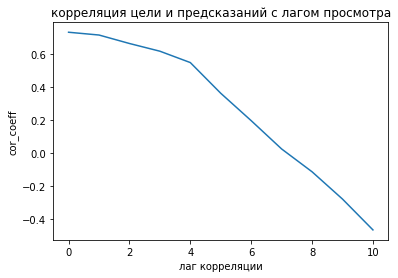

In [163]:
lag=10
p_cor=[np.corrcoef( Y_test_4, Y_test_pred_4)[1,0]]
for i in range(lag):
    c=np.corrcoef( Y_test_4[:-(i+1)], Y_test_pred_4[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) )  
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция цели и предсказаний с лагом просмотра')
plt.show()

#### 4

Возьмем срез последних 100 значений

In [164]:
X_test_100 = X_test_4[-100:].copy()
y_test_100 = Y_test_4[-100:].copy()

In [165]:
X_test_100 = X_test_100.reset_index(drop=True)

In [166]:
y_predict_4 = model_data_4.predict(X_test_100[0:3])

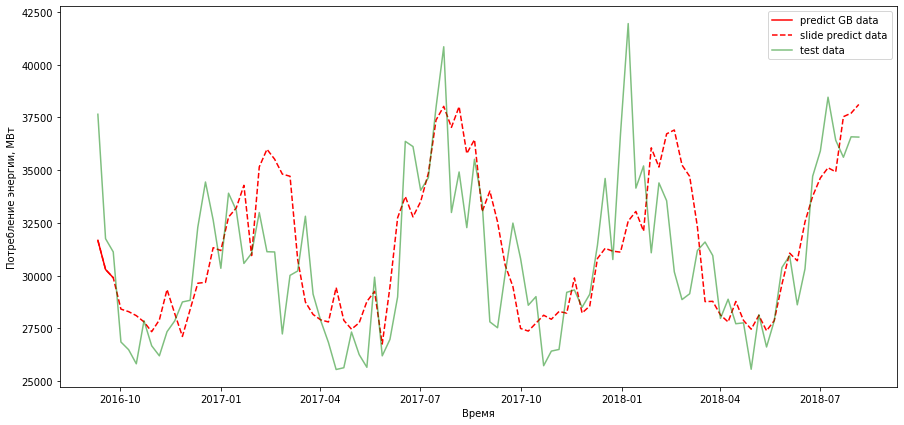

In [167]:
plt.figure( figsize=( 15, 7 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[36:39],y_predict_4, 'r',label='predict GB data' )
plt.plot(test.index[-100:],Y_test_pred_4[-100:], '--r',label='slide predict data')
plt.plot(test.index[-100:],Y_test_4[-100:], 'g',label='test data', alpha=0.5)
plt.legend()
plt.show()

In [168]:
er_4_mape = mean_absolute_percentage_error(Y_test_4[0:3],y_predict_4)

print('ошибка градиентного бустинга MAPE :  ', er_4_mape,'%')

ошибка градиентного бустинга MAPE :   18.417950450102815 %


In [169]:
er_4_mse = mean_squared_error(Y_test_4[0:3],y_predict_4)
er_4_mae = mean_absolute_error(Y_test_4[0:3],y_predict_4)
er_4_r2 = r2_score(Y_test_4[0:3],y_predict_4)

print('ошибка mse :  ', er_4_mse,'\nошибка mae  :  ', er_4_mae,'\nоценка R2 :  ', er_4_r2)

ошибка mse :   23053512.987002444 
ошибка mae  :   4765.740043446053 
оценка R2 :   -743.4959780050959


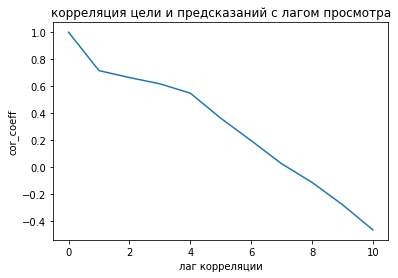

In [170]:
lag=10
p_cor=[np.corrcoef(Y_test_4[0:3],y_predict_4)[1,0]]
for i in range(lag):
    c=np.corrcoef(Y_test_4[:-(i+1)], Y_test_pred_4[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) )  
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция цели и предсказаний с лагом просмотра')
plt.show()

Значения метрик получились хуже чем у обычного прогноза

#### 5

1-10

In [171]:
y_predict_10 = model_data_4.predict(X_test_100[0:10])

In [199]:
er_10_mape = mean_absolute_percentage_error(Y_test_4[18:28],y_predict_10)

print('ошибка градиентного бустинга MAPE :  ', er_10_mape,'%')

ошибка градиентного бустинга MAPE :   6.237520135563162 %


In [200]:
er_10_mse = mean_squared_error(Y_test_4[18:28],y_predict_10)
er_10_mae = mean_absolute_error(Y_test_4[18:28],y_predict_10)
er_10_r2 = r2_score(Y_test_4[18:28],y_predict_10)

print('ошибка mse :  ', er_10_mse,'\nошибка mae  :  ', er_10_mae,'\nоценка R2 :  ', er_10_r2)

ошибка mse :   5761664.684515217 
ошибка mae  :   1873.2137712757176 
оценка R2 :   0.5382525370512624


11-20

In [202]:
y_predict_20 = model_data_4.predict(X_test_100[11:20])

In [203]:
er_20_mape = mean_absolute_percentage_error(Y_test_4[28:37],y_predict_20)

print('ошибка градиентного бустинга MAPE :  ', er_20_mape,'%')

ошибка градиентного бустинга MAPE :   4.658524805654805 %


In [204]:
er_20_mse = mean_squared_error(Y_test_4[28:37],y_predict_20)
er_20_mae = mean_absolute_error(Y_test_4[28:37],y_predict_20)
er_20_r2 = r2_score(Y_test_4[28:37],y_predict_20)

print('ошибка mse :  ', er_20_mse,'\nошибка mae  :  ', er_20_mae,'\nоценка R2 :  ', er_20_r2)

ошибка mse :   3080612.694902769 
ошибка mae  :   1488.3881781750797 
оценка R2 :   0.4229104959831358


21-30

In [205]:
y_predict_30 = model_data_4.predict(X_test_100[21:30])

In [206]:
er_30_mape = mean_absolute_percentage_error(Y_test_4[38:47],y_predict_30)

print('ошибка градиентного бустинга MAPE :  ', er_30_mape,'%')

ошибка градиентного бустинга MAPE :   11.273258846614521 %


In [207]:
er_30_mse = mean_squared_error(Y_test_4[38:47],y_predict_30)
er_30_mae = mean_absolute_error(Y_test_4[38:47],y_predict_30)
er_30_r2 = r2_score(Y_test_4[38:47],y_predict_30)

print('ошибка mse :  ', er_30_mse,'\nошибка mae  :  ', er_30_mae,'\nоценка R2 :  ', er_30_r2)

ошибка mse :   15613234.019646045 
ошибка mae  :   3417.355314131527 
оценка R2 :   -4.537007179942492


31-40

In [208]:
y_predict_40 = model_data_4.predict(X_test_100[31:40])

In [209]:
er_40_mape = mean_absolute_percentage_error(Y_test_4[48:57],y_predict_40)

print('ошибка градиентного бустинга MAPE :  ', er_40_mape,'%')

ошибка градиентного бустинга MAPE :   10.626928756703485 %


In [210]:
er_40_mse = mean_squared_error(Y_test_4[48:57],y_predict_40)
er_40_mae = mean_absolute_error(Y_test_4[48:57],y_predict_40)
er_40_r2 = r2_score(Y_test_4[48:57],y_predict_40)

print('ошибка mse :  ', er_40_mse,'\nошибка mae  :  ', er_40_mae,'\nоценка R2 :  ', er_40_r2)

ошибка mse :   9894095.557126835 
ошибка mae  :   2836.195485695237 
оценка R2 :   -4.974372104708167


41-50

In [211]:
y_predict_50 = model_data_4.predict(X_test_100[41:50])

In [212]:
er_50_mape = mean_absolute_percentage_error(Y_test_4[58:67],y_predict_50)

print('ошибка градиентного бустинга MAPE :  ', er_50_mape,'%')

ошибка градиентного бустинга MAPE :   7.496109124049605 %


In [213]:
er_50_mse = mean_squared_error(Y_test_4[58:67],y_predict_50)
er_50_mae = mean_absolute_error(Y_test_4[58:67],y_predict_50)
er_50_r2 = r2_score(Y_test_4[58:67],y_predict_50)

print('ошибка mse :  ', er_50_mse,'\nошибка mae  :  ', er_50_mae,'\nоценка R2 :  ', er_50_r2)

ошибка mse :   9527864.857585154 
ошибка mae  :   2629.8142837675423 
оценка R2 :   -0.537212367126511


51-60

In [214]:
y_predict_60 = model_data_4.predict(X_test_100[51:60])

In [215]:
er_60_mape = mean_absolute_percentage_error(Y_test_4[68:77],y_predict_60)

print('ошибка градиентного бустинга MAPE :  ', er_60_mape,'%')

ошибка градиентного бустинга MAPE :   8.07055077512366 %


In [216]:
er_60_mse = mean_squared_error(Y_test_4[68:77],y_predict_60)
er_60_mae = mean_absolute_error(Y_test_4[68:77],y_predict_60)
er_60_r2 = r2_score(Y_test_4[68:77],y_predict_60)

print('ошибка mse :  ', er_60_mse,'\nошибка mae  :  ', er_60_mae,'\nоценка R2 :  ', er_60_r2)

ошибка mse :   8337218.352943303 
ошибка mae  :   2360.6676560654414 
оценка R2 :   -0.5423105292315635


61-70

In [217]:
y_predict_70 = model_data_4.predict(X_test_100[61:70])

In [218]:
er_70_mape = mean_absolute_percentage_error(Y_test_4[78:87],y_predict_70)

print('ошибка градиентного бустинга MAPE :  ', er_70_mape,'%')

ошибка градиентного бустинга MAPE :   4.608614111513051 %


In [219]:
er_70_mse = mean_squared_error(Y_test_4[78:87],y_predict_70)
er_70_mae = mean_absolute_error(Y_test_4[78:87],y_predict_70)
er_70_r2 = r2_score(Y_test_4[78:87],y_predict_70)

print('ошибка mse :  ', er_70_mse,'\nошибка mae  :  ', er_70_mae,'\nоценка R2 :  ', er_70_r2)

ошибка mse :   4077883.857579359 
ошибка mae  :   1483.5233002767718 
оценка R2 :   0.5485585710713192


71-80

In [220]:
y_predict_80 = model_data_4.predict(X_test_100[71:80])

In [221]:
er_80_mape = mean_absolute_percentage_error(Y_test_4[88:97],y_predict_80)

print('ошибка градиентного бустинга MAPE :  ', er_80_mape,'%')

ошибка градиентного бустинга MAPE :   10.438104262110686 %


In [222]:
er_80_mse = mean_squared_error(Y_test_4[88:97],y_predict_80)
er_80_mae = mean_absolute_error(Y_test_4[88:97],y_predict_80)
er_80_r2 = r2_score(Y_test_4[88:97],y_predict_80)

print('ошибка mse :  ', er_80_mse,'\nошибка mae  :  ', er_80_mae,'\nоценка R2 :  ', er_80_r2)

ошибка mse :   12646924.442028938 
ошибка mae  :   3238.8429931292576 
оценка R2 :   -1.4827153969283997


81-90

In [223]:
y_predict_90 = model_data_4.predict(X_test_100[81:90])

In [224]:
er_90_mape = mean_absolute_percentage_error(Y_test_4[98:107],y_predict_90)

print('ошибка градиентного бустинга MAPE :  ', er_90_mape,'%')

ошибка градиентного бустинга MAPE :   3.9267777242604636 %


In [225]:
er_90_mse = mean_squared_error(Y_test_4[98:107],y_predict_90)
er_90_mae = mean_absolute_error(Y_test_4[98:107],y_predict_90)
er_90_r2 = r2_score(Y_test_4[98:107],y_predict_90)

print('ошибка mse :  ', er_90_mse,'\nошибка mae  :  ', er_90_mae,'\nоценка R2 :  ', er_90_r2)

ошибка mse :   2195327.263983977 
ошибка mae  :   1094.3455555558753 
оценка R2 :   -0.12858531099766313


91-100

In [226]:
y_predict_100 = model_data_4.predict(X_test_100[91:100])

In [227]:
er_100_mape = mean_absolute_percentage_error(Y_test_4[108:117],y_predict_100)

print('ошибка градиентного бустинга MAPE :  ', er_100_mape,'%')

ошибка градиентного бустинга MAPE :   5.6310321224876985 %


In [228]:
er_100_mse = mean_squared_error(Y_test_4[108:117],y_predict_100)
er_100_mae = mean_absolute_error(Y_test_4[108:117],y_predict_100)
er_100_r2 = r2_score(Y_test_4[108:117],y_predict_100)

print('ошибка mse :  ', er_100_mse,'\nошибка mae  :  ', er_100_mae,'\nоценка R2 :  ', er_100_r2)

ошибка mse :   5393355.590795846 
ошибка mae  :   1864.4717967229926 
оценка R2 :   0.46535394688488674


При различных интервалах ошибка меняется случайно

В зависимости от выбранного периода можно эффективно использовать различные методы прогноза